# Coupling
This notebook investigates coupled motion using transfer matrices.

## Setup 

In [1]:
import sys
import numpy as np
import numpy.linalg as la
import matplotlib
from matplotlib import pyplot as plt, animation, lines
import proplot as plot

sys.path.append('/Users/46h/Research/code/accphys')
from tools import (
    plotting as myplt,
    animation as myanim,
    envelope_analysis as ea,
    coupling as BL,
    matrix_lattice,
    utils)
from tools.envelope_analysis import Envelope
from tools.matrix_lattice import MatrixLattice, fodo
from tools.utils import show, play

In [2]:
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['style'] = None # `None` for default proplot style
plot.rc['savefig.dpi'] = 'figure' # proplot default is 1200, which makes inline animations appear huge

## Create lattice 

In [3]:
import importlib
importlib.reload(matrix_lattice)

L = 5.0
k1, k2 = 0.1, 0.1
lattice = fodo(k1, k2, L, fill_fac=0.5, quad_tilt=1, start='drift')

[ 2.7553891 +0.j          0.17366048-0.18146257j -2.7551946 -0.03273883j
  0.17149213+0.18351315j]


In [4]:
show(lattice.M, 'M', dec=3)
print()
lattice.print_params('2D')
print()
lattice.print_params('4D')

M =
⎡0.655   4.965  0.025   0.044⎤
⎢                            ⎥
⎢-0.032  1.28   0.012   0.025⎥
⎢                            ⎥
⎢0.019   0.036   1.28   4.965⎥
⎢                            ⎥
⎣0.006   0.019  -0.032  0.655⎦

2D lattice parameters
---------------------
mux = 14.63
muy = 14.63
nux = 0.04
nuy = 0.04
bx = 19.65
by = 19.65
ax = -1.24
ay = 1.24

4D lattice parameters
---------------------
a1x = -0.48
a1y = 0.48
a2x = -1.07
a2y = 1.07
b1x = 7.59
b1y = 7.59
b2x = 17.08
b2y = 17.08
u = 0.50
nu1 = -179.32
nu2 = -0.00
mu1 = 18.93
mu2 = 8.43


## Eigenvalues and eigenvectors 

Below the four eigenvalues are plotted in the complex plane. The eigenvalues will lie on the unit circle if the lattice is stable.

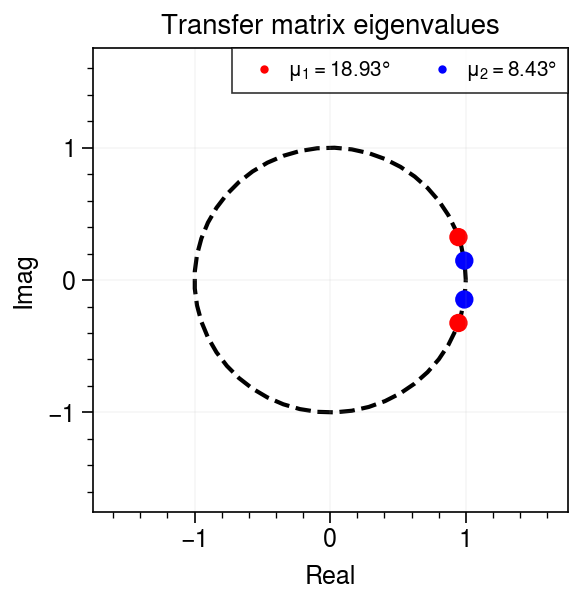

In [5]:
fig, ax = plot.subplots(figsize=(2.9, 3))
myplt.eigvals_complex_plane(ax, lattice.eigvals)
# ax.grid(alpha=0.2, color='lightgrey')
ax.set_title('Transfer matrix eigenvalues')
plt.savefig('eigvals.png', dpi=500, facecolor='white')

Track a particle which is a linear combination of the eigenvectors, i.e.:
$$
\mathbf{x} = Re \left[ \sqrt{\varepsilon_1}\mathbf{v}_1 e^{i\psi_1} + \sqrt{\varepsilon_2}\mathbf{v}_2 e^{i\psi_2} \right],
$$
where $\mathbf{v}_l$ are the eigenvectors, $\psi_l$ are initial phases, and $\varepsilon_l$ are initial amplitudes.

In [77]:
nturns = 1000
eps4D = 10 # [mm-mrad]
ratio = 0.05 # eps2 / eps1
psi1 = np.radians(0)
psi2 = np.radians(90)
norm_coords = False

In [78]:
# Determine emittances from provided ratio
if ratio == 0:
    eps1 = eps4D
else:
    eps1 = np.sqrt(eps4D / ratio)
eps2 = ratio * eps1

# Form coordinate vector
x1 = np.real(np.sqrt(eps1) * lattice.v1 * np.exp(1j*psi1)) # mode 1 contribution
x2 = np.real(np.sqrt(eps2) * lattice.v2 * np.exp(1j*psi2)) # mode 2 contribution
x = x1 + x2

# Track
X1 = lattice.track_part(x1, nturns, norm_coords=norm_coords)
X2 = lattice.track_part(x2, nturns, norm_coords=norm_coords)
X = lattice.track_part(x, nturns, norm_coords=norm_coords)

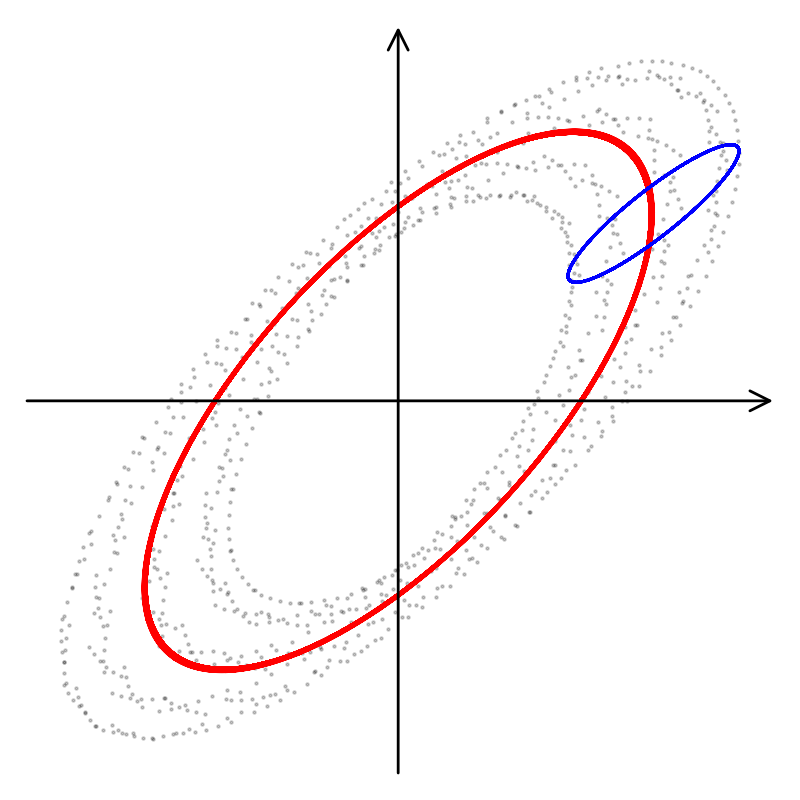

In [314]:
imax1 = np.argmax(X1, axis=0)
imax2 = np.argmax(X2, axis=0)
coords_at_xmax1 = X1[imax1[0]]
coords_at_xmax2 = X2[imax2[0]]

fig, ax = plt.subplots(figsize=(4, 4), tight_layout=True)
myplt.despine([ax], 'all')

# Plot ellipses
lw = 1
alpha = 1
ax.plot(X1[:, 0], X1[:, 1], color='r', alpha=alpha, lw=lw)
ax.plot(coords_at_xmax1[0] + X2[:, 0], coords_at_xmax1[1] + X2[:, 1], lw=lw, color='b', alpha=alpha)
ax.scatter(X[:, 0], X[:, 1], s=1, color='k', alpha=0.2)

# Draw x and y axis
xlim, ylim = ax.get_xlim(), ax.get_ylim()
myplt.vector(ax, [sum([abs(x) for x in xlim]), 0], origin=[xlim[0], 0], lw=1)
myplt.vector(ax, [0, sum([abs(y) for y in ylim])], origin=[0, ylim[0]], lw=1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# myplt.vector(ax, coords_at_xmax1[[0, 1]], c='r')
# myplt.vector(ax, coords_at_xmax2[[0, 1]], origin=coords_at_xmax1[[0, 1]], c='b')

plt.savefig('ellipses.png', dpi=500, facecolor='w')

In [54]:
anim = myanim.corner_onepart(
    X, vecs=[X1, X2], text_fmt='Period = {}', grid=False, 
    norm_labels=norm_coords, units=None if norm_coords else 'mm-mrad',
     fps=10, 
#      figname='eigvecs.mp4', dpi=900,
     s=5)
play(anim)

## Matched beam condition
A turn-by-turn particle trajectory will lie on a closed surface in phase space, and a matched beam is formed by distributing particles uniformly over this surface. The shape of the matched beam will be elliptical if is composed of a single eigenvector, which rotates at a single frequency in every projected plane, or if the eigentunes are equal, since the linear combination of two eigenvectors with the same eigenvalue is also an eigenvector.

In [48]:
X = lattice.matched_dist(1000, 'gaussian')
coords = lattice.track_bunch(X, nturns=10)
play(myanim.corner(coords, text_fmt='Turn = {}'))